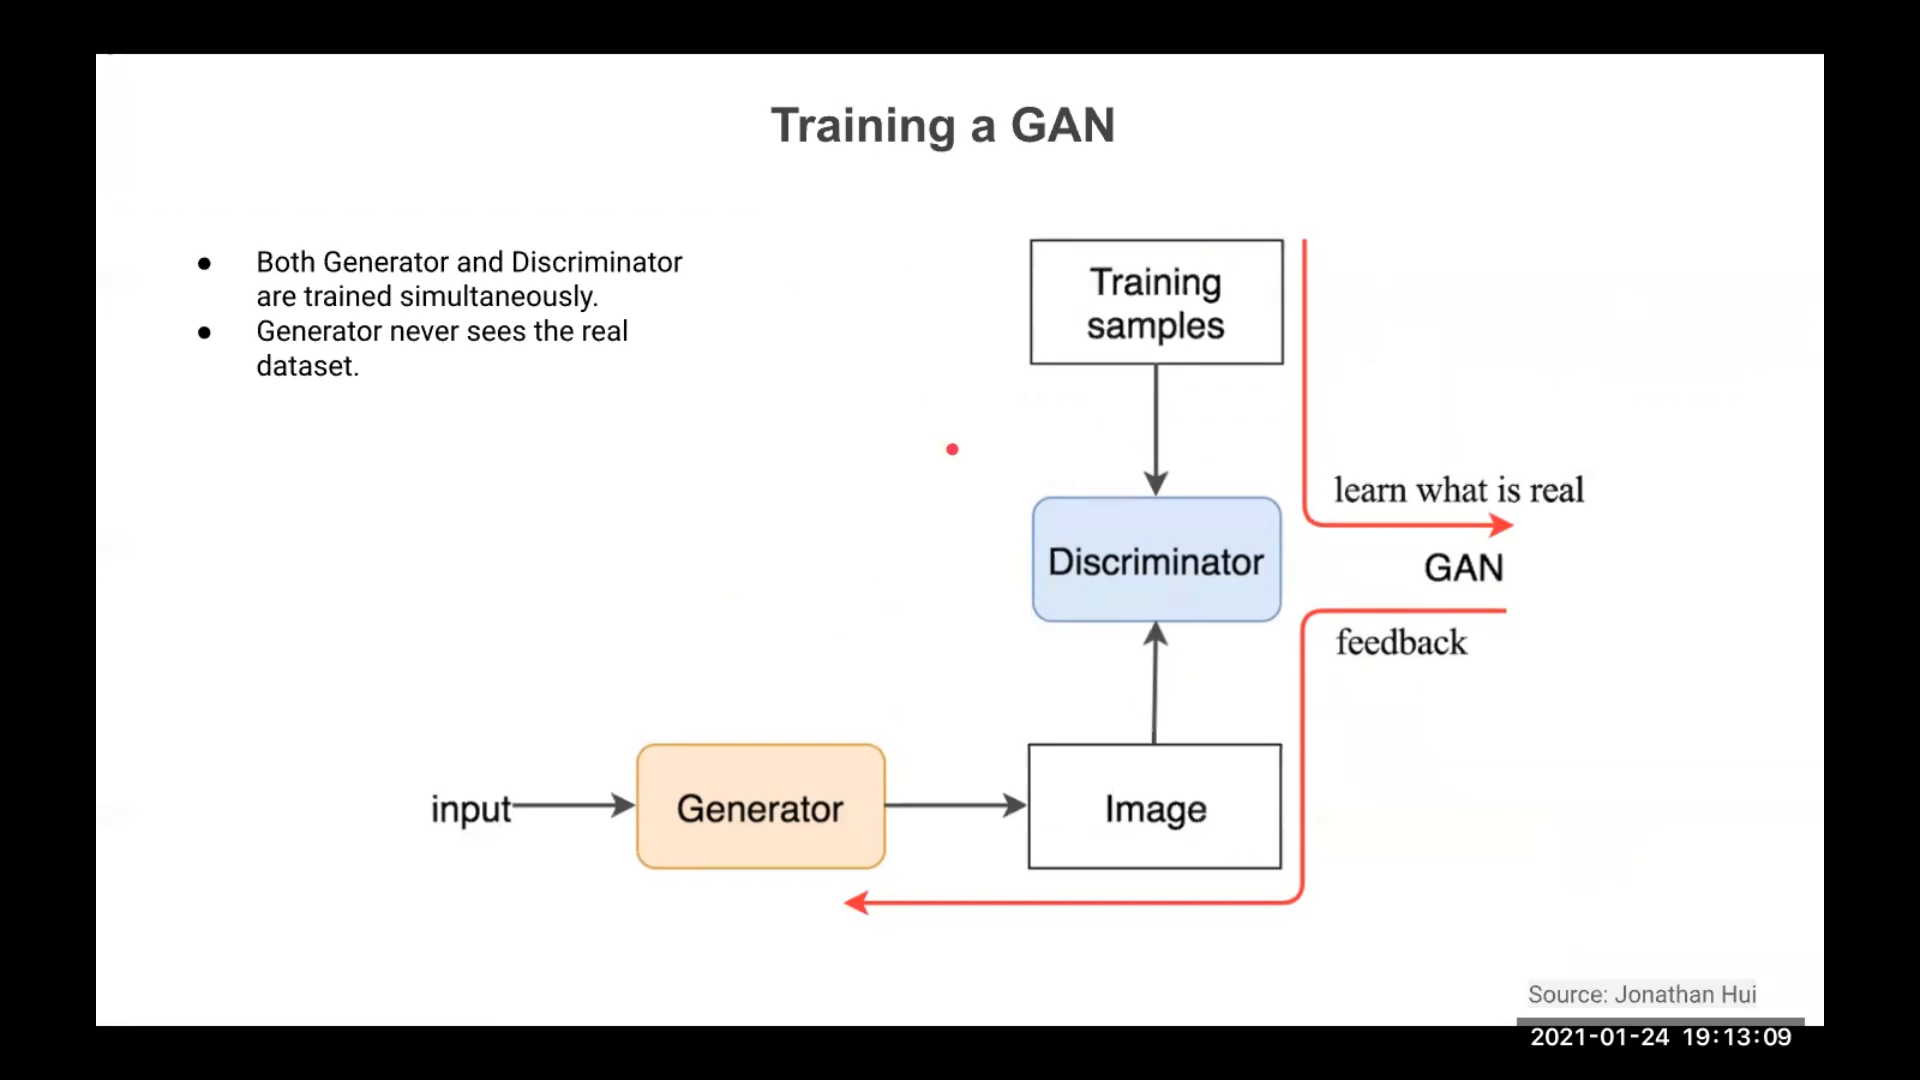

In [1]:
!pip install -q pytorch-lightning
!pip install -q pytorch-lightning-bolts

     |████████████████████████████████| 849kB 19.8MB/s 
     |████████████████████████████████| 112kB 57.3MB/s 
     |████████████████████████████████| 276kB 56.1MB/s 
     |████████████████████████████████| 184kB 52.3MB/s 
     |████████████████████████████████| 829kB 58.4MB/s 
     |████████████████████████████████| 1.3MB 52.8MB/s 
     |████████████████████████████████| 296kB 57.6MB/s 
     |████████████████████████████████| 143kB 57.4MB/s 
     |████████████████████████████████| 256kB 22.8MB/s 


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torch.optim import Adam

from tqdm.notebook import tqdm

from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

import pytorch_lightning as pl

In [10]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 1.33G/1.33G [00:07<00:00, 137MB/s]
100% 1.33G/1.33G [00:07<00:00, 200MB/s]


In [11]:
!unzip celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [12]:
def show_images(image_tensor,
                num_images=25,
                size=(2, 64, 64),
                ret=False):
  """
  Function for visualizing the images
  """
  image_tensor = (image_tensor+1) /2
  image_unflat = image_tensor.detach().cpu()
  image_grid = make_grid(image_unflat[:num_images], nrow=5)
  if ret:
    return image_grid.permute(1, 2, 0).squeeze()
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()


In [13]:
# Configurations are from DCGAN paper
z_dim = 100
batch_size = 128
lr = 0.0002

beta_1 = 0.5
beta_2 = 0.999

display_step = 500
device = 'cuda'
criterion = nn.BCEWithLogitsLoss()
path = './img_align_celeba/img_align_celeba'

In [14]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [67]:
class ImageDataset(Dataset):
  def __init__(self, path, transform = None):
    self.transform = transform
    self.files = glob(f'{path}/*')

  def __len__(self):
    return len(self.files)
  
  def __getitem__(self, idx):
    file = self.files[idx]
    label = file.split('/')[-1]
    image = Image.open(file)
    if self.transform:
      image = self.transform(image)
    return image, label

In [68]:
ds = ImageDataset(path, transform=transform)
dataloader = dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [77]:
def get_noise(cur_batch, z_dim, device):
  noise = torch.randn(cur_batch, z_dim, 1, 1, device = device)
  return noise

In [85]:
class Generator(nn.Module):
  def __init__(self, in_channels=3, z_dim=100):
    super(Generator, self).__init__()

    self.generator = nn.Sequential(
          self.create_upblock(z_dim, 1024,stride=1, padding = 0),
          self.create_upblock(1024, 512),
          self.create_upblock(512 , 256),
          self.create_upblock(256, 128),
          self.create_upblock(128, 3, final_layer = True),
      )
    
  def create_upblock(self, in_feat, out_feat, kernel_size=4,stride =2, padding =1, final_layer=False):
      if final_layer:
        return nn.Sequential(
            nn.ConvTranspose2d(in_feat,
                              out_feat,
                              kernel_size, 
                              stride,
                              padding,
                              bias = False),
                              nn.BatchNorm2d(out_feat),
                              nn.Tanh(),
                                         )
      return nn.Sequential(
          nn.ConvTranspose2d(in_feat,
                              out_feat,
                              kernel_size,
                              stride,
                              padding,
                              bias=False),
                              nn.BatchNorm2d(out_feat),
                              nn.ReLU(True)
                                    )

  def forward(self, noise):
    """
    noise: random vector of shape = (N, 100, 1, 1)
    """
    assert len(noise.shape) == 4

    return self.generator(noise)


In [86]:
class Discriminator(nn.Module):
  def __init__(self, in_chan = 3, hidden_dim=32):
    super(Discriminator, self).__init__()

    self.discriminator = nn.Sequential(
          self.make_disc_block(in_chan, hidden_dim),
          self.make_disc_block(hidden_dim, hidden_dim*2),
          self.make_disc_block(hidden_dim*2, hidden_dim*4, stride = 1),
          self.make_disc_block(hidden_dim*4, 1, final_layer=True) ,       
      )
    
  def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer = False):
      if not final_layer:
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2),
            )
      else:
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride)
        )

  def forward(self, image):
    disc_pred = self.discriminator(image)
    return disc_pred.view(len(disc_pred), -1)


In [87]:
disc = Discriminator()
disc(torch.randn(10, 3 ,64, 64)).shape

torch.Size([10, 16])

In [88]:
def weight_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [95]:
class GAN(pl.LightningModule):
  def __init__(self,
               learning_rate, 
               in_channels = 3, 
               hidden_dim=32,
               z_dim=100,
               **kwargs):
    super().__init__()

    self.z_dim = z_dim
    self.learning_rate = learning_rate

    self.generator = Generator(in_channels, z_dim=z_dim).to(device)
    self.discriminator = Discriminator(in_chan=in_channels,
                                       hidden_dim = hidden_dim).to(device)
    self.generator.apply(weight_init)
    self.discriminator.apply(weight_init)

    self.save_hyperparameters()
  
  def forward(self, noise):
    return self.generator(noise)

  def disc_step(self, x, noise):
    """
    x: real image
    """
    fake_images = self.generator(noise)
    real_logits = self.discriminator(x)
    fake_logits = self.discriminator(fake_images.detach())
    assert real_logits.shape == fake_logits.shape, f"Real and fake have different shapes: {real_logits.shape} and {fake_logits.shape}"

    # real loss
    real_loss = criterion(real_logits, torch.ones_like(real_logits))
    # fake loss
    fake_loss = criterion(fake_logits, torch.zeros_like(fake_logits))

    disc_loss = (fake_loss + real_loss) / 2

    assert disc_loss is not None
    self.log('disc_loss', disc_loss, on_epoch=True, prog_bar=True)
    return disc_loss
  
  def gen_step(self, x, noise):
    # generate fake images
    fake_images = self.generator(noise)

    fake_logits = self.discriminator(fake_images)
    gen_loss = criterion(fake_logits, torch.ones_like(fake_logits))

    assert gen_loss is not None
    self.log('gen_loss', gen_loss, on_epoch=True, prog_bar = True)
    return gen_loss

  def training_step(self, batch, batch_idx, optimizer_idx):
    x, _ = batch
    x = real = x.to(device)
    noise = get_noise(real.shape[0], self.z_dim, device = device)
    assert real.shape[1:] == (3, 64, 64), f"batch image data shape is incorrect: {real.shape}"

    if batch_idx % display_step==0 and optimizer_idx==0:
      fake_images = self.forward(noise)

      show_images(fake_images)
    
    loss = None
    # first get generator loss [opt_g, opt_d]
    if optimizer_idx == 0:
      loss = self.gen_step(real, noise)
    
    if optimizer_idx == 1:
      loss = self.disc_step(real, noise)
    return loss

  def configure_optimizers(self):
    lr = self.hparams.learning_rate

    opt_g = torch.optim.Adam(self.generator.parameters(),
                             lr = lr,
                             betas = (beta_1, beta_2))
    opt_d = torch.optim.Adam(self.discriminator.parameters(),
                             lr = lr,
                             betas = (beta_1, beta_2))
    return [opt_g, opt_d]

In [96]:
model = GAN(learning_rate=lr, z_dim=z_dim)
trainer = pl.Trainer(max_epochs=30, gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 12.7 M
1 | discriminator | Discriminator | 168 K 
------------------------------------------------
12.8 M    Trainable params
0         Non-trainable params
12.8 M    Total params
51.306    Total estimated model params size (MB)


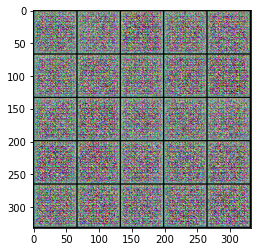

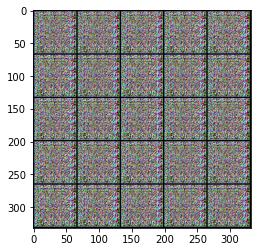

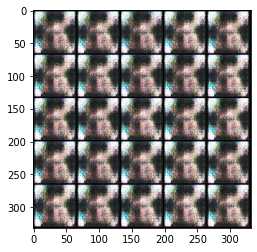

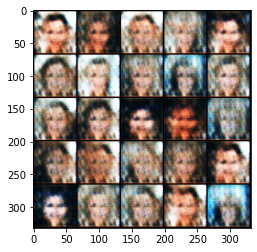

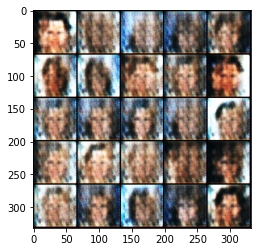

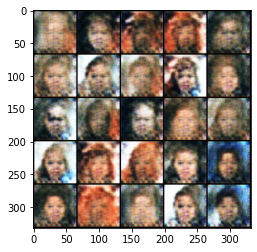

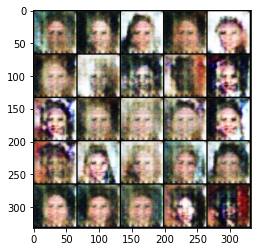

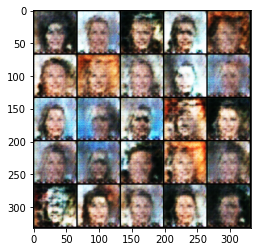

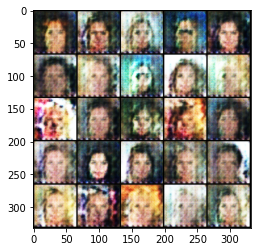

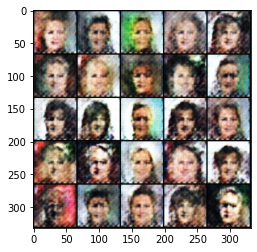

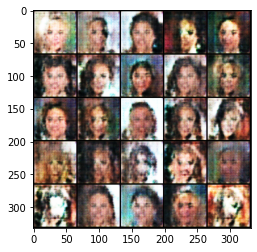

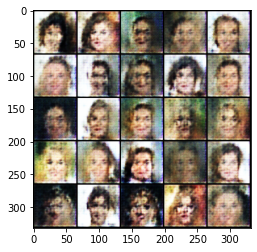

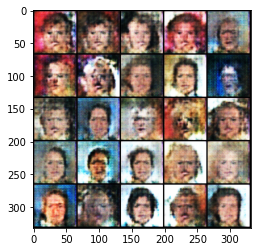

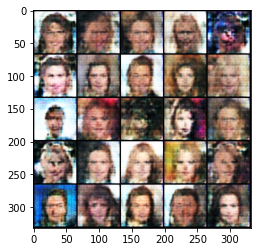

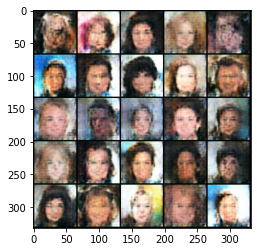

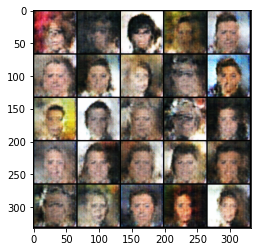

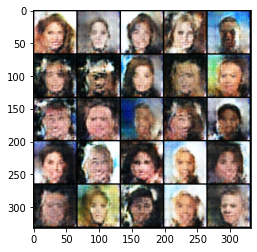

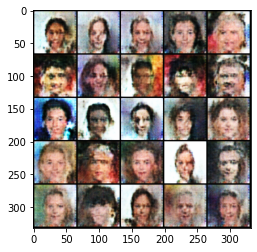

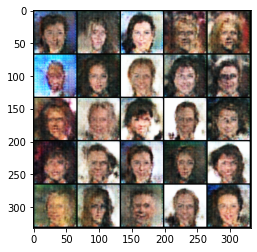

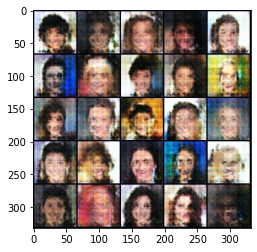

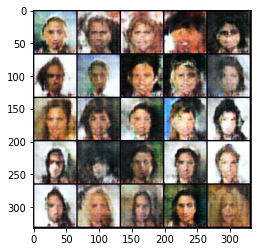

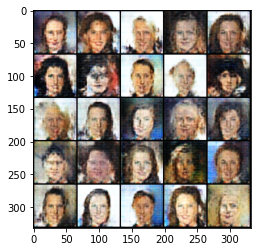

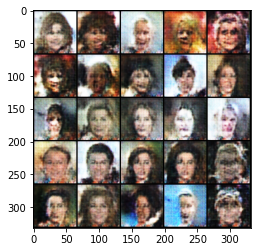

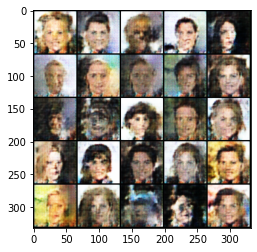

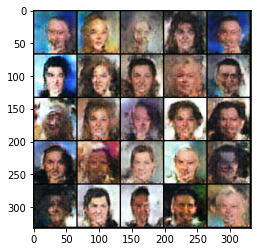

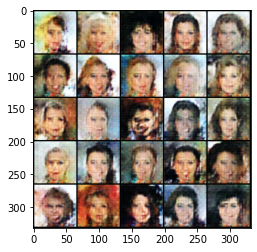

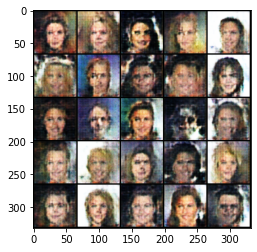

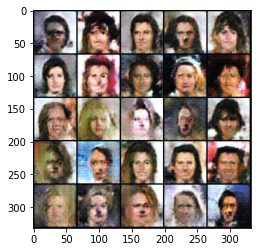

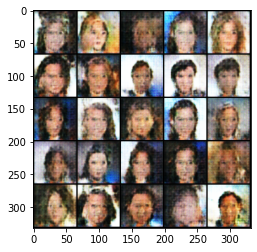

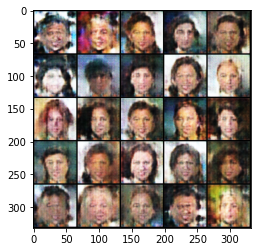

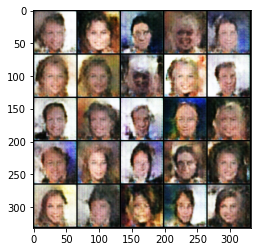

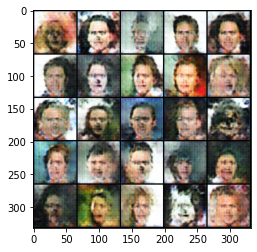

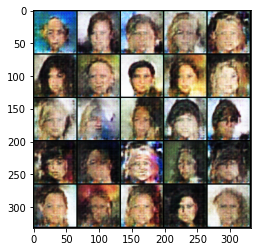

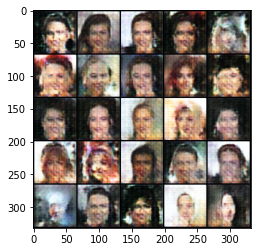

In [ ]:
trainer.fit(model, dl)